# Лабораторная работа 3. Линейные методы.

Результат лабораторной работы − отчет. Мы предпочитаем принимать отчеты в формате ноутбуков IPython (ipynb-файл). Постарайтесь сделать ваш отчет интересным рассказом, последовательно отвечающим на вопросы из заданий. Помимо ответов на вопросы, в отчете также должен быть код, однако чем меньше кода, тем лучше всем: нам − меньше проверять, вам — проще найти ошибку или дополнить эксперимент. При проверке оценивается четкость ответов на вопросы, аккуратность отчета и кода.

Мы уверены, что выполнение лабораторных работ занимает значительное время, поэтому не рекомендуем оставлять их на последний вечер перед сдачей.

### Оценивание и штрафы
* Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи)
* Максимально допустимая оценка за работу — 15 баллов
* Сдавать задание после указанного срока сдачи нельзя
* «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов и понижают карму (подробнее о плагиате см. на странице курса)
* Если вы нашли решение какого-то из заданий в открытом источнике, необходимо прислать ссылку на этот источник (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник)
* Не оцениваются задания с удалёнными формулировкам
* Не оценивается лабораторная работа целиком, если она была выложена в открытый источник

Обратите внимание, что мы не ставим оценку за просто написанный код, корректная работоспособность которого не подтверждена экспериментами.

### Правила сдачи
Выполненную работу следует отправить в систему Anytask. Более подробно о системе можно почитать на странице курса. Название отправляемого файла должно иметь следующий формат: Surname_Name_Group_NN.ipynb, где NN — номер лабораторной работы. Например, Kozlova_Anna_CS_03.ipynb.

<a id='log_reg'></a>
## Логистическая регрессия

В этом пункте мы будем рассматривать бинарную классификацию, где метки классов лежат во множестве $\{-1, 1\}$. 

Задачу обучения регуляризованной логистической регрессии можно записать следующим образом:

$$ \dfrac{1}{N}\sum_{i=1}^N \log(1 + \exp(-\langle w, x_i \rangle y_i)) + \dfrac{C}{2}\lVert w \rVert^2  \to \min_w$$

Обучение в данном случае сводится к нахождению параметров модели $w$, которое производится с помощью метода градиентного спуска (Gradient Descent, GD). 

Градиентный шаг будет заключаться в обновлении вектора весов по следующей формуле:

$$w := w + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w, x_i \rangle y_i)}\Big) - \eta Cw$$

где $\eta > 0$ — размер шага (learning rate).

В общем случае метод градиентного спуска имеет следующие недостатки:
- попадание в локальные минимумы
- неочевидность критерия останова
- выбор размера шага
- начальная инициализация весов

В этой части лабораторной работы мы предложим вам реализовать метод градиентного спуска, а также рассмотрим некоторые его модификации.



In [1]:
import numpy as np
import pandas as pd
import pylab as plt
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from abc import ABCMeta, abstractmethod

In [4]:
from sklearn.datasets import make_classification, make_regression
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_blobs, make_circles, make_moons
from sklearn.multiclass import OneVsOneClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC

In [5]:
import scipy.linalg as sla
import scipy.sparse as sps
import scipy.sparse.linalg as spla
import scipy as sp

In [6]:
from sklearn.decomposition import PCA

def projection(X_in, y_in):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_in)

    plt.title("Projection on 2D")
    plt.xlabel('X0')
    plt.ylabel('X1')
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_in,  alpha=0.6)

### Задание

Сгенерируйте выборку из 1000 точек с 20 признаками на которой будете проводить эксперименты. Мы рекомендуем воспользоваться функцией [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) из пакета sklearn. Обратите внимание, что метки классов для данной задачи должны быть из множества {-1, 1} (по умолчанию make_classification возвращает метки из множества {0, 1}).

((1000, 20), (1000,))

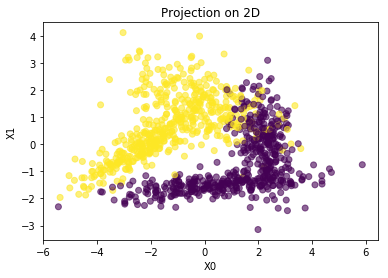

In [7]:
X, y = make_classification(n_samples=1000, n_features=20, random_state=49)
y[y==0] = -1

projection(X, y)

X.shape, y.shape

**(3 балла)** Реализуйте градиентный спуск и протестируйте его для случая логистической регрессии на ранее сгенерированной выборке. Для сравнения качества разных подходов используйте значение оптимизируемого функционала.

В качестве критерия останова мы предлагаем использовать следующие условия:
 - евклидова норма разности текущего и нового векторов весов стала меньше, чем 1e-4
 - ограничение на число итераций (например, 10000)
 
Для начальной инициализации весов нужно сравнить следующие подходы:
 - нулевая начальная инициализация
 - случайная
 
Выполните следующие пункты и прокомментируйте полученные результаты:
- Рассмотрите как влияет размер шага на сходимость (попробуйте не менее 5-ти различных значений).
- Рассмотрите регуляризованную модель (не менее 5-ти различных коэффициентов регуляризации), которая описана выше, а также модель без регуляризатора. Сравните влияет ли наличие регуляризации на скорость сходимости и качество (под качеством во всех случаях подразумевается значение исходного, нерегуляризованного функционала).
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации (при правильной реализации и подходящем размере шага он должен убывать).
- Влияет ли выбор начальной инициализации весов на скорость и качество?

В каждом пункте требуется построить необходимые графики скорости/качества и дать исчерпывающие выводы.

**Вычисление значения и градиента у *Logistic Loss* **

In [8]:
class Logistic():
    def __init__(self):
        pass

    def value(self, X, y, w, C):
        yXw = np.multiply(y, X.dot(w))
        div = 1.0/len(X)
        funcw = (np.logaddexp(0, -(yXw))).sum()*div + C*0.5*w.T.dot(w)
        return funcw    
    
    def gradient(self, X, y, w, C):
        yXw = np.multiply(y, X.dot(w))
        div = 1.0/len(X)
        sigma = sp.special.expit(yXw)
        gradw = (X.T).dot((sigma - 1)*y)*div + C*w
        return gradw

*Мини тесты*

In [9]:
w = np.zeros(X.shape[1])
loss = Logistic()

In [10]:
from sklearn.linear_model import logistic as log_sk
print("my logistic\n", loss.value(X, y, w, 1.0))
print("sklearn logistic\n", log_sk._logistic_loss(w, X, y, 1.0)*(1/len(X)))

my logistic
 0.6931471805599454
sklearn logistic
 0.6931471805599454


$$[\nabla f(x)]_i \approx \frac{f(x + \epsilon \cdot e_i) - f(x)}{\epsilon}~~~~$$

где $e_i = (0, ... , 0, 1, 0, ..., 0)$ - i-й базисный орт, $\epsilon \approx 10^{-8}$

In [11]:
def max_error(a, b): 
    return np.max(np.abs(a-b))

def grad_finite_diff(func, w, eps=1e-8):
    w, fval, dnum = w.astype(np.float64), func(w), np.zeros_like(w)
    for i in range(w.size):
        ei = np.zeros(w.size)
        ei[i] = 1
        dnum[i] = (func(w + eps * ei) - fval) / eps
    return dnum

In [12]:
mat_grad = loss.gradient(X, y, w, 1.0)
num_grad = grad_finite_diff(lambda w: loss.value(X, y, w, 1.0), w)

err = max_error(mat_grad, num_grad)
print('err = ', err, 'ok' if err < 1e-6 else 'ошибка очень большая =(')

err =  2.0637399435197157e-08 ok


*Функция Логистик Лосс успешно протестирована.

**Базовый класс опитизационных задач.** *Очень пригодиться *

In [30]:
class OptSolver(BaseEstimator, ClassifierMixin, metaclass=ABCMeta):  
    def __init__(self, loss, alpha=1.0, max_iter=100, tol=1e-4, random_state=32):
        self.loss = loss
        self.alpha = alpha
        self.tol = tol
        self.max_iter = max_iter
        self.random_state = random_state
                
        self.n_iter_ = 0
        self.first_run = True
        self.coef_ = None
        self.way_ = None
    
    @abstractmethod
    def gradient_step(self, X, y, w):
        """step"""
        
    def fit(self, X, y, coef_init=None):
        
        np.random.seed(self.random_state)
        self.first_run = True
        self.way_ = []
        n, m = X.shape
        if coef_init is None:
            coef_init = np.zeros(m)
            
        w = coef_init
        self.way_.append(self.loss.value(X, y, w, self.alpha))
        for i_iter in range(self.max_iter):
            self.n_iter_ = i_iter
            
            w_old = w
            w = self.gradient_step(X, y, w)
            
            self.first_run = False
            loss_value = self.loss.value(X, y, w, self.alpha)
                    
            if self.tol is not None:
                if sla.norm(w_old - w) < self.tol:
                    break

            self.way_.append(loss_value)
            
        self.coef_ = w
        return self
    
    def predict(self, X):
        pass

**Реализация *Gradient Descent* **

In [31]:
class GradientDescent(OptSolver):  
    def __init__(self, loss, alpha=1.0, max_iter=100, eta0=0.1, tol=1e-4, random_state=32):
        super().__init__(
            loss=loss, alpha=alpha, tol=tol,
            max_iter=max_iter)
        self.eta0 = eta0
        
    def gradient_step(self, X, y, w):
        return w - self.eta0*self.loss.gradient(X, y, w, self.alpha)

**Скорость сходимости от выбора шагового множителя**

eta 0.001 n_iter 99
eta 0.05 n_iter 99
eta 0.01 n_iter 99
eta 0.5 n_iter 9
eta 0.1 n_iter 57


Text(0,0.5,'Log Loss value')

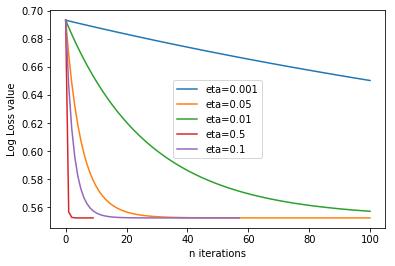

In [15]:
gd = GradientDescent(Logistic(), alpha=1.0, max_iter=100, tol=1e-5, random_state=65)
w0 = np.zeros(X.shape[1])
etas = [1e-3, 5e-2, 1e-2, 5e-1, 1e-1]
for eta in etas:
    gd.set_params(eta0=eta)
    gd.fit(X, y, coef_init=w0)
    way = gd.way_
    print("eta {} n_iter {}".format(eta, gd.n_iter_))
    plt.plot(way, label=f'eta={eta}')
    
plt.legend()
plt.xlabel("n iterations")
plt.ylabel("Log Loss value")

*Видно, что чем больше шаг тем быстрее сходится. При 0.5 градиетный метод сошелся всего за 9 шагов!*

**Влияние выбора начальной точки на скорость сходимости**

n_iter 499
n_iter 266


Text(0,0.5,'Log Loss value')

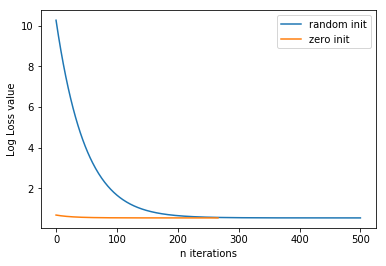

In [16]:
w0 = np.random.randn(X.shape[1])
gd = GradientDescent(Logistic(), alpha=1.0, max_iter=500, eta0=1e-2, tol=1e-4, random_state=65)
gd.fit(X, y, coef_init=w0)
way = gd.way_
plt.plot(way, label='random init')
print("n_iter {}".format(gd.n_iter_))

w0 = np.zeros(X.shape[1])
gd.fit(X, y, coef_init=w0)
way = gd.way_
plt.plot(way, label='zero init')
print("n_iter {}".format(gd.n_iter_))

plt.legend()

plt.xlabel("n iterations")
plt.ylabel("Log Loss value")

*В данном случае, получается что при рандомном выборе точки, мы гораздо дольше будем сходиться, чем при нулевой. Скорее всего, просто повезло.*

**Влияние регулиризации на скорость сходимости**

C 0.0001 n_iter 599
C 0.01 n_iter 599
C 0.1 n_iter 599
C 0 n_iter 599
C 1 n_iter 266


Text(0,0.5,'Log Loss value')

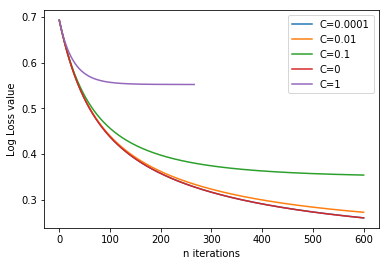

In [33]:
gd = GradientDescent(Logistic(), alpha=100.0, max_iter=600, eta0=1e-2, tol=1e-4, random_state=65)
w0 = np.zeros(X.shape[1])
gridC = [1e-4, 1e-2, 1e-1, 0, 1]
for C in gridC:
    gd.set_params(alpha=C)
    gd.fit(X, y, coef_init=w0)
    way = gd.way_
    plt.plot(way, label=f'C={C}')
    print("C {} n_iter {}".format(C, gd.n_iter_))
    
plt.legend()
plt.xlabel("n iterations")
plt.ylabel("Log Loss value")

*Регулиризация оказывает сильное влияние на скорость сходимости. Но с другой стороны, регулиризатор меняет сильно целевую функцию и выводы о скорости сходимости по факту разных функций не совсем честно делать. Видно что при большем значении **С** мы имеем большее значение функции (что логично собственно) и опитимизационная задача сходиться быстро к этому значению.*

Метод градиентного спуска может быть весьма трудозатратен в случае большого размера обучающей выборки. Поэтому обычно используют метод стохастического градиентного спуска, где на каждой итерации выбирается случайный объект из обучающей выборки и обновление весов происходит сразу по этому объекту. 

**(1.5 балл)** Реализуйте метод стохастического градиентного спуска (sgd). В этом случае вы можете выбрать наиболее удачный функционал, исходя из предыдущего пункта (с регуляризацией, без), а также схему начальной инициализации весов. Реализуйте метод в виде класса, удовлетворяющего интерфейсу scikit-learn ([тут есть пример](http://danielhnyk.cz/creating-your-own-estimator-scikit-learn/)).

Сравните рассмотренные методы (градиентный спуск и sgd) между собой с точки зрения скорости сходимости и качества.

- Посмотрите как влияет размер шага на сходимость (попробуйте 4-5 различных значений)
- Исследуйте качество оптимизируемого функционала в зависимости от номера итерации

Выберите лучший размер шага и сравните качество и скорость сходимости реализованного метода и [его аналога из scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html) (не забудьте выставить значения важных параметров tol и learning_rate для сравнения методов в приближённо равных условиях). Насколько получилось лучше/хуже, в чём могут быть причины?

В каждом пункте сделайте исчерпывающие выводы, подкреплённые графиками.

**Реализуем метод *SGD* c выбором одного sample**

In [37]:
class SGD(OptSolver):  
    def __init__(self, loss, alpha=1.0, max_iter=100, eta0=0.1, tol=1e-4, random_state=32):
        super().__init__(
            loss=loss, alpha=alpha, tol=tol,
            max_iter=max_iter, random_state=random_state)
        self.eta0 = eta0
        
    def gradient_step(self, X, y, w):
        n, m = X.shape
        random_ind = np.random.randint(n)

        X_batch = X[random_ind]
        y_bacth = y[random_ind]
        return w - self.eta0*self.loss.gradient(X_batch, y_bacth, w, self.alpha)

*Сравнение **GD** и **SGD***

Text(0,0.5,'Log Loss value')

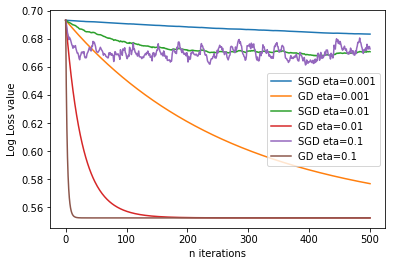

In [38]:
sgd = SGD(Logistic(), alpha=1.0, max_iter=500, tol=None, random_state=65)
gd = GradientDescent(Logistic(), alpha=1.0, max_iter=500, tol=None, random_state=65)

w0 = np.zeros(X.shape[1])
etas = [1e-3, 1e-2, 1e-1]
for eta in etas:
    sgd.set_params(eta0=eta)
    gd.set_params(eta0=eta)
    sgd.fit(X, y, coef_init=w0)
    gd.fit(X, y, coef_init=w0)
    way_sgd = sgd.way_
    way_gd = gd.way_

    plt.plot(way_sgd, label=f'SGD eta={eta}')
    plt.plot(way_gd, label=f'GD eta={eta}')
    
plt.legend()
plt.xlabel("n iterations")
plt.ylabel("Log Loss value")

*Метод **SGD** показывает хуже результаты сходимости, чем **GD**, а иногда даже вообще не сходиться. Чем больше шаговый множитель, тем больше метод колеблеться и больше шанс ни к чему не сойтись.*

**Сравнение нашей реализации *SGD* с реализацией *sklearn* **

In [43]:
sgd = SGD(Logistic(), alpha=1.0, max_iter=100, tol=None, random_state=123, eta0=0.1)
sgd_sklearn = linear_model.SGDClassifier(loss='log', alpha=1.0, penalty='l2', max_iter=100, tol=None,
                                         random_state=123, eta0=0.1, fit_intercept=False,
                                         learning_rate='constant', shuffle=False)
gd = GradientDescent(Logistic(), alpha=1.0, max_iter=100, tol=None, random_state=123, eta0=0.1)

w0 = np.zeros(X.shape[1])

sgd.fit(X, y, coef_init=w0)
sgd_sklearn.fit(X, y, coef_init=w0)
gd.fit(X, y, coef_init=w0)

loss = Logistic()

w_sgd = sgd.coef_
w_sgd_sklearn = sgd_sklearn.coef_.ravel()
w_gd = gd.coef_


print("My sgd {}".format(loss.value(X, y, w_sgd, 1.0)))
print("Sklearn sgd {}".format(loss.value(X, y, w_sgd_sklearn, 1.0)))
print("My gd {}".format(loss.value(X, y, w_gd, 1.0)))

My sgd 0.6602102479964591
Sklearn sgd 0.6446464834073828
My gd 0.5523803098257154


*Ну по полученному значению функции видно, что мы не так сильно отстаем от **sklearn**. Возможно реализация **sklearn** использует не один sample, а batch.*

**(0.5 балла)** Добавьте в выборку случайный шум следующим способом:
 1. Выберите случайно 3% объектов из сгенерированной ранее выборки.
 2. Сдвиньте эти объекты на $\mathcal{N}(0; 3 * scale)$, где $scale$ —  масштаб, который был использован при генерации объектов (параметр $scale$ в make_classification).
 3. Инвертируйте классы выбранных объектов.
 
Для GD и SGD сравните скорость сходимости и значение функции потерь до и после добавления шума. Сделайте необходимые выводы, подкреплённые графиками.

**Добавление шума**

In [44]:
np.random.seed(42)
X_noise = X.copy()
y_noise = y.copy()
for i in range(int(X.shape[0]*0.3)):
    ind = np.random.randint(X.shape[0])
    X_noise[ind] = X[ind] + np.random.normal(loc=0.0, scale=3.0, size=X.shape[1])
    y_noise[ind] = -y[ind]

((1000, 20), (1000,))

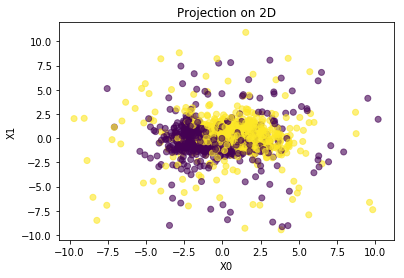

In [45]:
projection(X_noise, y_noise)

X_noise.shape, y_noise.shape

**Сравнение скорости сходимости *SGD* и *GD* без добавления шума и с добавлением шума.**

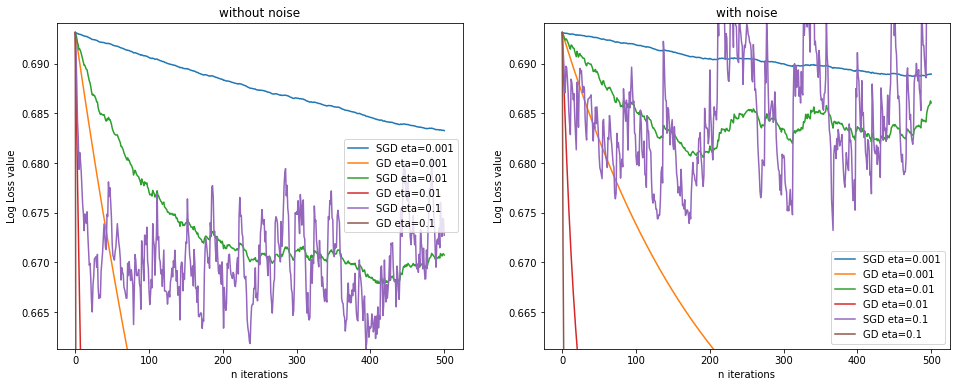

In [52]:
sgd = SGD(Logistic(), alpha=1.0, max_iter=500, tol=None, random_state=65)
gd = GradientDescent(Logistic(), alpha=1.0, max_iter=500, tol=None, random_state=65)
w0 = np.zeros(X.shape[1])

fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

etas = [1e-3, 1e-2, 1e-1]
for eta in etas:
    sgd.set_params(eta0=eta)
    gd.set_params(eta0=eta)
    
    sgd.fit(X, y, coef_init=w0)
    gd.fit(X, y, coef_init=w0)
    way_sgd = sgd.way_
    way_gd = gd.way_

    f_min, f_max = min(way_sgd), max(way_sgd) + 0.001
    
    ax1.set_title("without noise")
    ax1.plot(way_sgd, label=f'SGD eta={eta}')
    ax1.plot(way_gd, label=f'GD eta={eta}')
    
    ax1.legend()
    ax1.set_xlabel("n iterations")
    ax1.set_ylabel("Log Loss value")
    ax1.set_ylim([f_min, f_max])
    
    sgd.fit(X_noise, y_noise, coef_init=w0)
    gd.fit(X_noise, y_noise, coef_init=w0)
    way_sgd = sgd.way_
    way_gd = gd.way_

    ax2.set_title("with noise")
    ax2.plot(way_sgd, label=f'SGD eta={eta}')
    ax2.plot(way_gd, label=f'GD eta={eta}')
    ax2.set_ylim([f_min, f_max])

    ax2.legend()
    ax2.set_xlabel("n iterations")
    ax2.set_ylabel("Log Loss value")

*Скорость сходимости в обоих методах ухудшилась, как само значение функции потерь.*

Между обновлением вектора весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окрестности. 

![](http://sebastianruder.com/content/images/2015/12/without_momentum.gif)

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

![](http://nghenglim.github.io/images/2015061300.png)

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{\theta}{J(\theta)}$$
$$ \theta = \theta - v_t$$

где

 - $\theta$ — вектор параметров (в нашем случае — $w$)
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное отличие данного метода от SGD состоит в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженным данным большого объема. 

Обозначим градиент по параметру $\theta_i$ на итерации $t$ как $g_{t,i} = \nabla_{\theta}J(\theta_i)$. 

В случае sgd обновление параметра $\theta_i$ будет выглядеть следующим образом:

$$ \theta_{t+1, i} = \theta_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ \theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $\theta_{i}$ до $t$-ой итерации. $\varepsilon$ — гиперпараметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом (здесь $\odot$ — матричное умножение):

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична гиперпараметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 
$$\Delta \theta_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $\theta$:

$$ E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1-\gamma)\Delta \theta^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta \theta_t = - \dfrac{RMS[\Delta \theta^2]}{RMS[ga^2]} g_t $$ 
$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - статья про [momentum](https://pdfs.semanticscholar.org/97da/c94ffd7a7ac09a4218848300cc7e98569d77.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) разных способов оптимизации

### Задание

Реализуйте метод оптимизации *Momentum* **(0.5 балла)** и один из *Adagrad*/*Adadelta* **(1 балл)**.
- Сравните оба метода с классическим sgd с точки зрения скорости сходимости.
- Посмотрите как значение гиперпараметра $\gamma$ влияет на скорость сходимости и качество в методе *Momentum*.

В заданиях выше требуется построить графики и описать полученные результаты.

Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

**Реализация метода *Momentum***

In [55]:
class Momentum(OptSolver):  
    def __init__(self, loss, alpha=1.0, max_iter=100, eta0=0.1, momentum_term=0.9, tol=1e-4, random_state=32):
        super().__init__(
            loss=loss, alpha=alpha, tol=tol,
            max_iter=max_iter, random_state=random_state)
        self.eta0 = eta0
        self.momentum_term = momentum_term
        
    def gradient_step(self, X, y, w):
        n, m = X.shape
        random_ind = np.random.randint(n)

        X_batch = X[random_ind]
        y_bacth = y[random_ind]
        
        if self.first_run:
            self.v = np.zeros(w.shape)

        bv = self.v*self.momentum_term
        self.v = bv + self.eta0*self.loss.gradient(X_batch, y_bacth, w - bv, self.alpha)
        return w - self.v

**Сравнение скорости сходимости с *SGD***

Text(0,0.5,'Log Loss value')

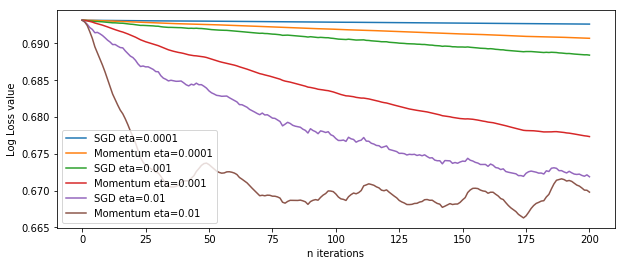

In [60]:
sgd = SGD(Logistic(), alpha=1.0, max_iter=200, tol=None, random_state=65)
momentum = Momentum(Logistic(), alpha=1.0, max_iter=200, tol=None, random_state=65, momentum_term=0.8)

fig = plt.figure(figsize=(10,4))

w0 = np.zeros(X.shape[1])
etas = [1e-4, 1e-3, 1e-2]
for eta in etas:
    sgd.set_params(eta0=eta)
    momentum.set_params(eta0=eta)
    sgd.fit(X, y, coef_init=w0)
    momentum.fit(X, y, coef_init=w0)
    way_sgd = sgd.way_
    way_momentum = momentum.way_

    plt.plot(way_sgd, label=f'SGD eta={eta}')
    plt.plot(way_momentum, label=f'Momentum eta={eta}')
    
plt.legend()
plt.xlabel("n iterations")
plt.ylabel("Log Loss value")

*Видно, во всех случаях **Momentum** дает лучше результаты и быстрее сходиться. Видимо осцилляции действительно помогают.*

**Зависимоть гиперпараметра $\gamma$ на скорость сходимости и качество.**

Text(0,0.5,'Log Loss value')

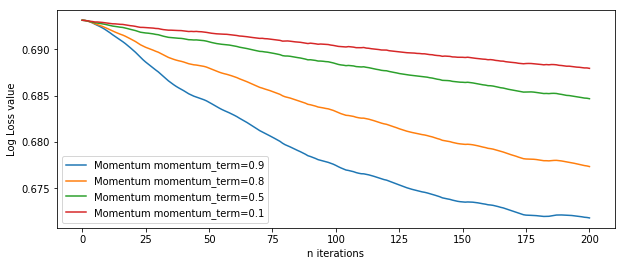

In [62]:
momentum = Momentum(Logistic(), alpha=1.0, max_iter=200, tol=None, random_state=65, eta0=0.001, momentum_term=0.8)

fig = plt.figure(figsize=(10,4))

w0 = np.zeros(X.shape[1])
terms = [0.9, 0.8, 0.5, 0.1]
for term in terms:
    momentum.set_params(momentum_term=term)
    momentum.fit(X, y, coef_init=w0)
    way_momentum = momentum.way_

    plt.plot(way_momentum, label=f'Momentum momentum_term={term}')
    
plt.legend()
plt.xlabel("n iterations")
plt.ylabel("Log Loss value")

*Чем больше **momentum term** тем быстрее мы сходимся. Чем меньше, тем более метод схож с обычным **SGD**.*

**Реализация метода *Adagrad* **

In [65]:
class AdaGrad(OptSolver):  
    def __init__(self, loss, alpha=1.0, max_iter=100, eta0=0.1, eps=1e-8, tol=1e-4, random_state=32):
        super().__init__(
            loss=loss, alpha=alpha, tol=tol,
            max_iter=max_iter, random_state=random_state)
        self.eps = eps
        self.eta0 = eta0
        
    def gradient_step(self, X, y, w):
        n, m = X.shape
        random_ind = np.random.randint(n)

        X_batch = X[random_ind]
        y_bacth = y[random_ind]
        
        gradient = self.loss.gradient(X_batch, y_bacth, w, self.alpha)
        
        if self.first_run:
            self.accum_grad = np.zeros(w.shape)
        else:
            self.accum_grad += gradient**2
        
        self.accum_grad 
        inv_accum_grad = self.eta0 / np.sqrt(self.eps + self.accum_grad)

        return w - inv_accum_grad*gradient

**Сравнение скорости и сходимости и качества *SGD* и *AdaGrad***

Text(0,0.5,'Log Loss value')

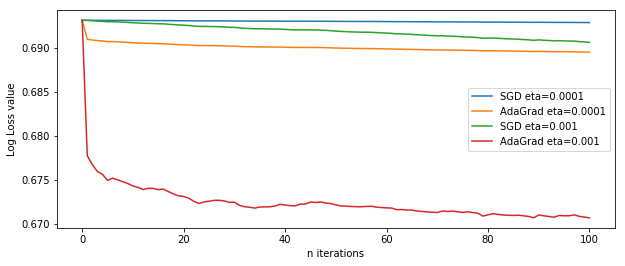

In [69]:
sgd = SGD(Logistic(), alpha=1.0, max_iter=100, tol=None, random_state=65)
adagrad = AdaGrad(Logistic(), alpha=1.0, max_iter=100, tol=None, random_state=65, eps=1e-6)

fig = plt.figure(figsize=(10,4))

w0 = np.zeros(X.shape[1])
etas = [1e-4, 1e-3]
for eta in etas:
    sgd.set_params(eta0=eta)
    adagrad.set_params(eta0=eta)
    sgd.fit(X, y, coef_init=w0)
    adagrad.fit(X, y, coef_init=w0)
    way_sgd = sgd.way_
    way_adagrad = adagrad.way_

    plt.plot(way_sgd, label=f'SGD eta={eta}')
    plt.plot(way_adagrad, label=f'AdaGrad eta={eta}')
    
plt.legend()
plt.xlabel("n iterations")
plt.ylabel("Log Loss value")

*Намного лучше картина при использование адаптивного шага. **AdaGrad** сходится быстрее и показывает лучше качество чем стандартный **SGD**. *

### Многоклассовая классификация

Модель логистической регрессии можно обобщить для случая многоклассовой классификации. Метка класса теперь лежит во множестве $\{1, 2, ..., K\}$. Параметры модели $w$ в этом случае являются матрицей размерности $K \times M$, где $M$ − количество признаков. Обучение модели логистической регрессии в многоклассовом случае будет выглядеть следующим образом:

$$ -\dfrac{1}{N}\sum_{i=1}^N \sum_{k=1}^K [y_i = k] \log\Big(\frac{\exp(\langle w_k, x_i \rangle)}{\sum_{s=1}^K \exp(\langle w_s, x_i \rangle))}\Big) + \dfrac{C}{2}\lVert w \rVert^2  \to \min_w$$

Здесь $w_k$ обозначает $k$-ую строку матрицы $w$.

Обучать эту модель также можно с помощью градиентного спуска.

Кроме того существует другой, более универсальный способ решать задачу многоклассовой классификации. Для этого нужно обучить несколько бинарных моделей классификации, после чего на основании предсказаний по этим моделям вынести окончательный вердикт о принадлежности объекта одному из $K$ классов. Существует две популярные стратегии использования бинарных классификаторов для задачи многоклассовой классификации:
 - OvR (One-vs-Rest, One-vs-All) − стратегия, при которой каждый из $K$ классификаторов обучается отделять объекты одного класса от объектов всех остальных классов. В качестве предсказания используется тот класс, классификатор которого предсказал наибольшую вероятность среди всех.
 - OvO (One-vs-One) − стратегия, при которой каждый из $\frac{K(K-1)}{2}$ классификаторов учится разделять объекты пары классов, игнорируя объекты всех остальных классов. На этапе предсказания класс обычно выбирается путем голосования по вердиктам каждого из классификаторов.


### Задание

**(0.5 балла)** Покажите, что функция потерь для многоклассовой классификации сводится к [функции потерь для бинарной классификации](#log_reg) при $K=2$.
 

*Нужно доказать, что* $$ -\sum_{k=1}^K [y_i = k] \log\Big(\frac{\exp(\langle w_k, x_i \rangle)}{\sum_{s=1}^K \exp(\langle w_s, x_i \rangle))}\Big)$$
*сводится к*
$$ \log(1 + \exp(-\langle w, x_i \rangle y_i))$$
*Докательство:*
$$ -\sum_{k=1}^K [y_i = k] \log\Big(\frac{\exp(\langle w_k, x_i \rangle)}{\sum_{s=1}^K \exp(\langle w_s, x_i \rangle))}\Big) =  -[y_i = 1] \log\Big(\frac{\exp(\langle w_1, x_i \rangle)}{\sum_{s=1}^K \exp(\langle w_s, x_i \rangle))}\Big) - [y_i = 2] \log\Big(\frac{\exp(\langle w_1, x_i \rangle)}{\sum_{s=1}^K \exp(\langle w_s, x_i \rangle))}\Big) = ...$$
$$\sum_{s=1}^K \exp(\langle w_s, x_i \rangle)) = \exp(\langle w_1, x_i \rangle)) + \exp(\langle w_2, x_i \rangle)$$
$$ ... = -[y_i = 1] \log\Big(\frac{\exp(\langle w_1, x_i \rangle)}{\exp(\langle w_1, x_i \rangle)) + \exp(\langle w_2, x_i \rangle)}\Big) - [y_i = 2] \log\Big(\frac{\exp(\langle w_2, x_i \rangle)}{\exp(\langle w_1, x_i \rangle)) + \exp(\langle w_2, x_i \rangle)}\Big) = $$ 
$$= -[y_i = 1] \log\Big(\frac{1}{1 + \exp(\langle w_2, x_i \rangle - \langle w_1, x_i \rangle)}\Big) - [y_i = 2] \log\Big(\frac{1}{\exp(\langle w_1, x_i \rangle- \langle w_2, x_i \rangle) + 1}\Big) = $$
$$= [y_i = 1] \log\Big(1 + \exp(\langle w_2, x_i \rangle- \langle w_1, x_i \rangle)))\Big) + [y_i = 2] \log\Big(1 + \exp(\langle w_1, x_i \rangle)) - \langle w_2, x_i \rangle)\Big) = $$
*Перейдём в обозначения классов +- 1*
$$= [y_i = 1] \log\Big(1 + \exp(\langle w_{-1}, x_i \rangle- \langle w_1, x_i \rangle)))\Big) + [y_i = -1] \log\Big(1 + \exp(\langle w_1, x_i \rangle)) - \langle w_{-1}, x_i \rangle)\Big) = $$
$$=\log\Big(1 + \exp(y_i(\langle w_{-1}, x_i \rangle)) - \langle w_{1}, x_i \rangle))\Big) =\log\Big(1 + \exp(y_i(\langle w_{-1} - w_1, x_i \rangle))\Big)$$
*Совпадает с выражением для бинарной классификации при $w = w_{1} - w_{-1}$*

**(1 балл)** 
Сгенерируйте несколько выборок точек с 2 признаками и 3 классами (по 100 объектов каждого класса) на которых будете проводить эксперименты. Для этого можно воспользоваться функцией [make_blobs](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html) из пакета sklearn.

Обучите [логистическую регрессию](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) из пакета sklearn тремя различными способами:
 - в режиме multinomial, оптимизирующем многоклассовую функцию потерь
 - в режиме OvR
 - в режиме OvO
 
Первые два способа реализованы в самом классе LogisticRegression, в то время как для решения задачи третьим методом в sklearn реализован класс [OneVsOneClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html) (класс для OvR схемы [OneVsRestClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html), конечно, также присутствует в пакете).
 
 
 Проделайте следующие шаги для каждой стратегии и прокомментируйте полученные результаты:
 - Изобразите точки выборки, а также разделяющие прямые (их должно быть по 3 для каждой из стратегий). Проведите эксперимент на всех сгенерированных выборках.
 - Какие особенности, преимущества и недостатки с точки зрения построения разделяющих плоскостей, качества разделения классов и вычислительной эффективности характерны для каждого метода? Дайте развёрнутый ответ.
 - Для каждой из стратегий приведите примеры ситуаций, когда стоит выбирать ее для решения задачи многоклассовой классификации. Обоснуйте


**Изображение выборки и разделяющих прямых**

In [72]:
def plot_classes(ax, clf, X, y, title=""):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    print("training score : %.3f (%s)" % (clf.score(X, y), title))
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, cmap='Pastel1')
    ax.set_title(title)
    ax.axis('tight')
    colors = "rbg"
    for i, color in zip(clf.classes_, colors):
        idx = np.where(y == i)
        ax.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired)

**Перебор всех стратегий**

In [73]:
def multinomil_stategy(X, y):
    fig = plt.figure(figsize=(20,6))

    multi_class = 'multinomial'
    clf = LogisticRegression(solver='lbfgs', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    ax = fig.add_subplot(131)
    plot_classes(ax, clf, X, y, multi_class)

    multi_class = 'ovr'
    clf = LogisticRegression(solver='lbfgs', max_iter=100, random_state=42,
                             multi_class=multi_class).fit(X, y)

    ax = fig.add_subplot(132)
    plot_classes(ax, clf, X, y, multi_class)

    multi_class = 'ovo'
    clf = OneVsOneClassifier(LogisticRegression(solver='lbfgs', max_iter=100, random_state=42)).fit(X, y)

    ax = fig.add_subplot(133)
    plot_classes(ax, clf, X, y, multi_class)

**Пускай классы равномерно расположены от центра.**

training score : 0.970 (multinomial)
training score : 0.970 (ovr)
training score : 0.970 (ovo)


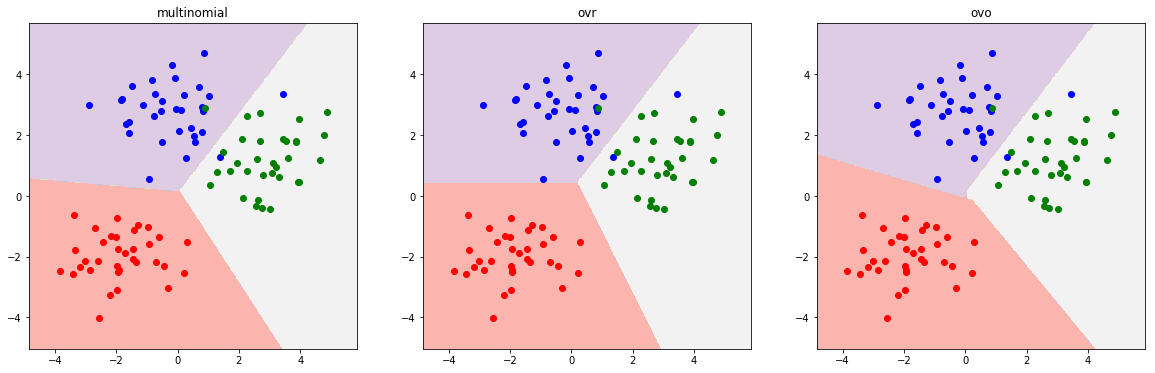

In [74]:
centers = [[-2, -2], [0, 3], [3, 1]]
X, y = make_blobs(n_samples=100, centers=centers, random_state=40)
multinomil_stategy(X, y)

*Все стратегии справились одинакого хорошо, но если приглядеться стратегия **ovo** построила для зеленого класа не такую ровную плосколсть как стратгии **multinomial** и **ovr***

**Пускай классы расоложены вдоль кривой.**

training score : 0.900 (multinomial)
training score : 0.850 (ovr)
training score : 0.900 (ovo)


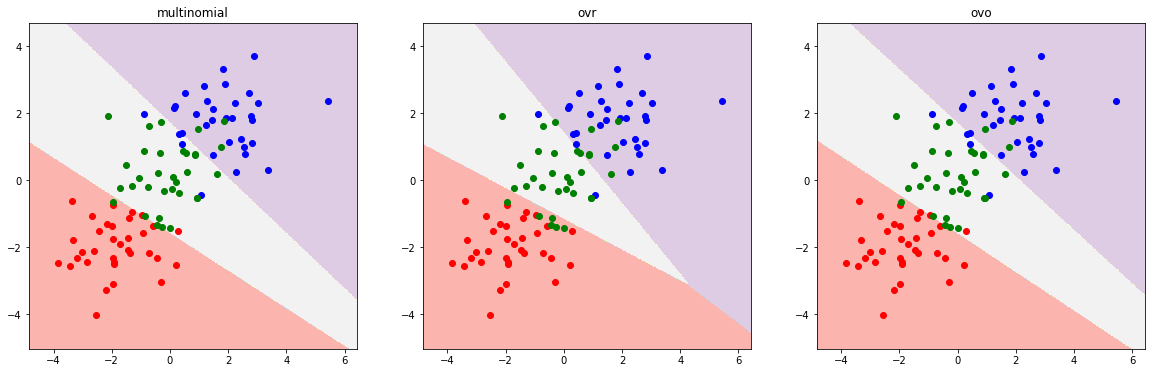

In [76]:
centers = [[-2, -2], [2, 2], [0, 0]]
X, y = make_blobs(n_samples=100, centers=centers, random_state=40)
multinomil_stategy(X, y)

*Хуже всех тут справился **ove** он не построил для зеленого класса хорошую плоскость вдоль кривой, как мы задумали.*

**Пускай два класса смешаны, а третий разделим.**

training score : 0.800 (multinomial)
training score : 0.800 (ovr)
training score : 0.800 (ovo)


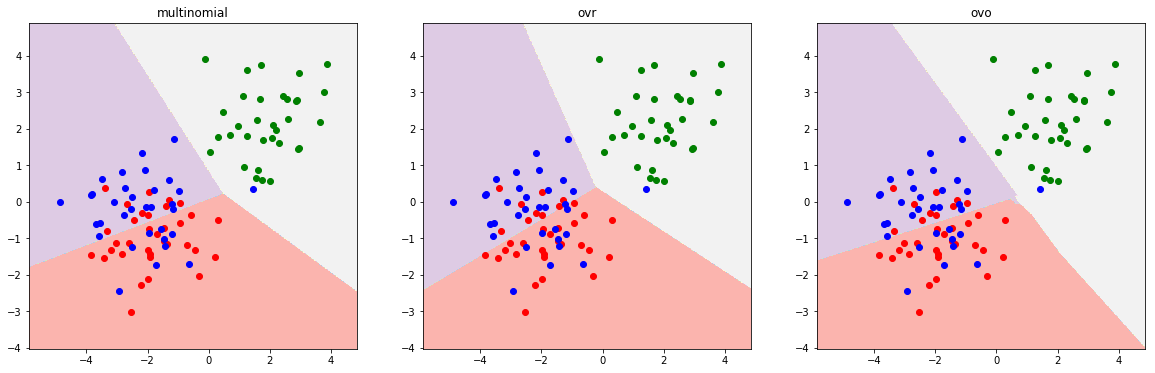

In [375]:
centers = [[-2, -1], [-2, 0], [2, 2]]
X, y = make_blobs(n_samples=100, centers=centers, random_state=40)
multinomil_stategy(X, y)

*По нашей задумке хороше справился метод **ovo**.*

*Все стратегии показывали достойный результат на моих сгенерированных выборках. Лучше всего на 3 классах показал резульат **ovo**.*

*Наиболее эффективен **ovr**, так как в нём обучается 3 (=числу классов) бинарных классификатора, что в общем случае вычислительно быстрее, чем **ovo** (N(N-1)/2 бинарных классификаторов, в нашем случае количества классов равны, **ovo** даже быстрее, так как в нём каждый классификатор обучается по меньшему числу объектов), и также быстрее многомерной логистической регрессии.*

## Линейная регрессия

![](http://66.147.244.197/~globerov/introspectivemode/wp-content/uploads/2012/08/regression-265x300.jpeg)

Метод градиентного спуска позволяет оптимизировать произвольные функции. Например, рассмотрим задачу линейной регрессии, где $y \in \mathbb{R}$, а алгоритм будет иметь вид $a(x) = \langle w, x\rangle$. В случае метода наименьших квадратов оптимизируемый функционал можно записать следующим образом:

$$ \sum_{i=1}^N (\langle w, x_i \rangle - y_i) ^ 2 \to \min_w$$

Эта задача интересна тем, что для нее можно выписать аналитическое решение. Попробуем сравнить эти подходы.

### Задание

Сгенерируйте выборку из 600 точек с двумя признаками для задачи регрессии, воспользовавшись функцией [make_regression](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_regression.html#sklearn.datasets.make_regression). 

In [78]:
X, y = make_regression(n_samples=600, n_features=2, random_state=43)
X.shape, y.shape

((600, 2), (600,))

In [79]:
from sklearn.daal4sklearn import dispatcher
dispatcher.disable()

**(0.5 балла)** Выпишите как выглядит точное решение задачи линейной регрессии. Решите задачу регрессии с помощью этого подхода без использования и с использованием регуляризации. Есть ли недостатки у такого подхода к решению задачи?

$$\beta = (X^TX + \tau I_n)^{-1}X^TY$$

In [80]:
l2_reg = 0.1

**Линейная регрессия с аналитическим решением**

In [81]:
class LinearRegression(BaseEstimator, ClassifierMixin):
    def __init__(self, alpha=0):
        self.alpha = alpha
        self.coef_ = None
        
    def fit(self, X, y):
        if self.alpha == 0:
            self.coef_ = (sla.inv(X.T.dot(X)).dot(X.T)).dot(y)
        else:
            self.coef_ = sla.inv(X.T.dot(X) + self.alpha*np.eye(X.shape[1])).dot(X.T).dot(y)
        return self

In [82]:
reg = LinearRegression().fit(X, y)
true_solve = reg.coef_

In [83]:
reg = LinearRegression(alpha=l2_reg).fit(X, y)
true_solve_reg = reg.coef_

In [84]:
print(true_solve)
print(true_solve_reg)

[32.15602535 53.77609112]
[32.15060811 53.76619115]


*Основным недостатком это численная неустойчивость при обособенной матрице.*

**(0.5 балла)** Примените метод стохастического градиентного спуска реализованный ранее. Сильно ли отличается полученный вектор параметров по сравнению с точным решением? 

**Для этого надо реализовать нахождение градиента и вычисления значение у функции потерь MSE**

In [85]:
class MSE():
    def __init__(self):
        pass

    def value(self, X, y, w, C):
        Xw = X.dot(w)
        funcw = (y - Xw).sum() + C*w.T.dot(w)
        return funcw    
    
    def gradient(self, X, y, w, C):
        Xw = X.dot(w)
        e = y - Xw
        gradw = X.T.dot(e)
        return -2.0*gradw + 2.0*C*w

In [86]:
sgd = SGD(MSE(), alpha=0.0, max_iter=1000, tol=1e-7, random_state=65)
sgd_coeff = sgd.fit(X, y).coef_
print(sgd_coeff)

[32.15602607 53.77609245]


In [87]:
sgd = SGD(MSE(), alpha=l2_reg, max_iter=1000, tol=1e-7, random_state=65)
sgd_coeff_l2 = sgd.fit(X, y).coef_
print(sgd_coeff_l2)

[27.43543562 50.63733395]


In [88]:
print(sgd_coeff - true_solve)
print(sgd_coeff_l2 - true_solve_reg)

[7.16589469e-07 1.33508983e-06]
[-4.71517249 -3.12885721]


*Без регулиризации решение получается почти идентичным. Разница в 7 знаке. С регулиризацией, к сожалению, результат получался намного дальше от аналитического.*

К сожалению, линейная регрессия позволяет хорошо восстанавливать *линейные* зависимости, однако в общем случае хуже работает с более сложными данными. Это хорошо можно увидеть на следующем примере.

Пусть исходная зависимость имеет вид $y = x \cdot sin(x)$. Сгенерируем соответствующие точки:

In [89]:
from sklearn.model_selection import train_test_split

In [90]:
X = np.linspace(0, 10, 100)
y = X * np.sin(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

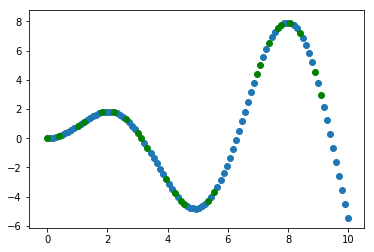

In [91]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')

Если теперь к полученным данным применить модель линейной регрессии, то получим следующее решение:

In [92]:
from sklearn.linear_model import LinearRegression

In [93]:
lr = LinearRegression()
lr.fit(X_train[:, np.newaxis], y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

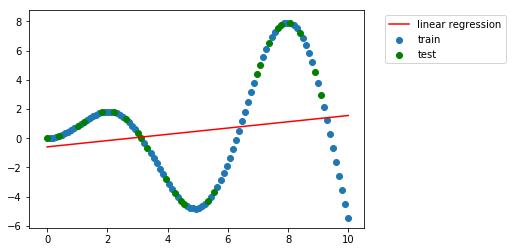

In [94]:
_ = plt.scatter(X_train, y_train)
_ = plt.scatter(X_test, y_test, c='g')
y_plot = lr.predict(X[:, np.newaxis])
_ = plt.plot(X, y_plot, c='r')
_ = plt.legend(('linear regression', 'train', 'test'), bbox_to_anchor=(1.05, 1), loc=2)

Качество модели регрессии можно оценивать с помощью некоторых метрик, например $MSE = \sum_{i=1}^l(a(x_i) - y_i)^2$ и в данном случае оно равно:

In [95]:
from sklearn.metrics import mean_squared_error

In [96]:
mean_squared_error(y_test, lr.predict(X_test[:, np.newaxis])) 

14.759977502823233

Построенное решение совсем отдаленно напоминает исходную зависимость. Одним из способов улучшить результат является добавление всех попарных произведений признаков, а также степеней: $x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2, \dots$

### Задание

**(0.5 балла)** Воспользуйтесь классом [PolynomialFeatures](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures) и добавьте к данным зависимости $y = x \cdot sin(x)$ различные полиномы.

 - рассмотрите как степень полинома (от 1 до 20) влияет на качество
 - изобразите на графике предсказание аналогично линейной регрессии
 - сравните этот подход с функцией [polyfit](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.polyfit.html)

В чем могут быть недостатки такого подхода?

**Степень полинома на качество решения**

minimum MSE 4.944186624410295e-09 in degree = 12


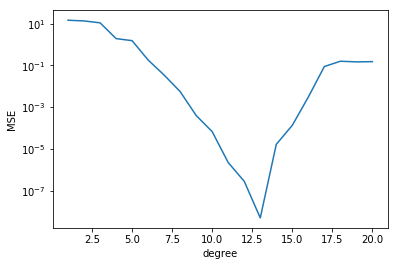

In [102]:
lr = LinearRegression()
mses = np.empty(0)

degrees = range(1, 21)

for degree in degrees:
    pf = PolynomialFeatures(degree)
    X_train_pf = pf.fit_transform(X_train[:, np.newaxis])
    X_test_pf = pf.transform(X_test[:, np.newaxis])
    
    lr.fit(X_train_pf, y_train)
    
    mse = mean_squared_error(y_test, lr.predict(X_test_pf))
    mses = np.append(mses, mse)

plt.plot(degrees, mses)
plt.yscale('log')
plt.xlabel("degree")
plt.ylabel("MSE")
# print(mses)
min_mse = min(mses)
min_degree = np.argmin(mses)

print("minimum MSE {} in degree = {}".format(min_mse, min_degree))

In [103]:
def PolyPlot(ax, degree):
    pf = PolynomialFeatures(degree)
    X_train_pf = pf.fit_transform(X_train[:, np.newaxis])
    X_test_pf = pf.transform(X_test[:, np.newaxis])
    lr.fit(X_train_pf, y_train)
    ax.scatter(X_train, y_train)
    ax.scatter(X_test, y_test, c='g')
    y_plot = lr.predict(pf.transform(X[:, np.newaxis]))
    ax.plot(X, y_plot, c='r')
    ax.set_title("degree {}".format(degree))

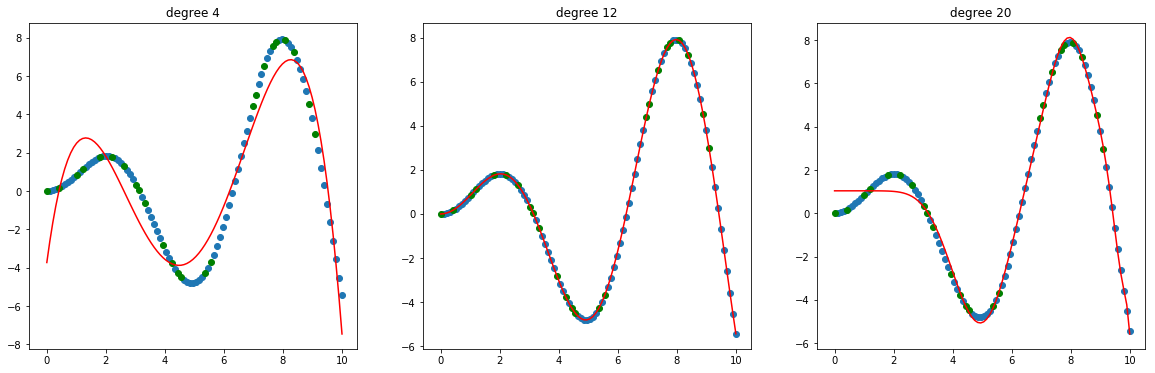

In [104]:
fig = plt.figure(figsize=(20,6))

ax = fig.add_subplot(131)
PolyPlot(ax, 4)

ax = fig.add_subplot(132)
PolyPlot(ax, min_degree)

ax = fig.add_subplot(133)
PolyPlot(ax, 20)

*При небольшой степень кривая слабо подстроилась под наши данные. При оптимальном 12-ти степеней кривая почти идельно прошлась по данным, при большем количестве степеней кривая куда то съехала.*

In [105]:
polyfit_mses = np.empty(0)

for degree in degrees:
    polyfit = np.polyfit(X_train, y_train, deg=degree)
    y_pred = np.poly1d(polyfit)(X_test)
    mse = mean_squared_error(y_test, y_pred)
    polyfit_mses = np.append(polyfit_mses, mse)

PolynomialFeatures: minimum MSE 4.944186624410295e-09 in degree = 12
polyfit: minimum MSE 8.922721218076331e-18 in degree = 18


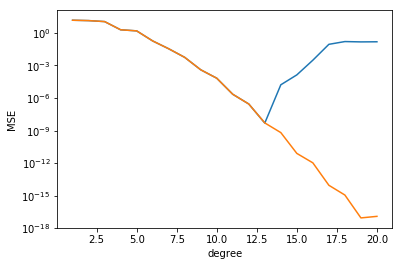

In [106]:
plt.plot(degrees, mses)
plt.plot(degrees, polyfit_mses)

plt.yscale('log')
plt.xlabel("degree")
plt.ylabel("MSE")

min_mse_poly = min(polyfit_mses)
min_degree_poly = np.argmin(polyfit_mses)

print("PolynomialFeatures: minimum MSE {} in degree = {}".format(min_mse, min_degree))
print("polyfit: minimum MSE {} in degree = {}".format(min_mse_poly, min_degree_poly))

*Видно, что **polyfit** лучше работает при больших степенях полинома: ошибка PolynomialFeatures при степенях больше 12 начинает увеличиваться, а ошибка polyfit продолжает уменьшаться.*

*Недостаток такого подхода может проявиться при наличии шума в данных. Полином высокой степени сможет подстроиться под такие данные, однако это не даст хороший результат в итоге.*

## Линейный SVM

Вернемся к задаче бинарной классификации. Будем обозначать обучающую выборку $\{(x_n, y_n)\}_{n=1}^N$, где $N$ — количество объектов, $\boldsymbol x_n \in \mathbb{R}^d$ — числовой вектор признакового описания объекта, $y_n \in \{+1, -1\}$ — класс объекта.

SVM обучает модель разделяющей гиперплоскости:
$$f(\boldsymbol x) = \boldsymbol w^T \boldsymbol x + b$$
Параметры модели — вектор весов $\boldsymbol w \in \mathbb{R}^d$ и сдвиг $b \in \mathbb{R}$.

Обучение модели происходит путем решения оптимизационной задачи:
$$
\begin{gather}
    \frac{1}{2} \| \boldsymbol w \|^2 + C \sum_{n=1}^N \xi_n \to \min_{\boldsymbol w, \boldsymbol \xi, b} \\
    \text{s.t.: } \quad y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1 - \xi_n, \quad \xi_n \geq 0, \quad \forall n=1,\dots,N
\end{gather}
$$

Ограничения вида $y_n (\boldsymbol w^T \boldsymbol x_n + b) \geq 1$ требуют, чтобы объекты правильно классифицировались разделяющей гиперплоскостью. Поскольку линейная разделимость выборки не гарантируется на практике, вводят переменные $\xi_n$ (slack variables), которые ослабляют ограничения правильной классификации. В оптимизируемом функционале слагаемое $\| \boldsymbol w \|^2$ штрафует малую ширину разделяющей гиперплоскости, сумма $\sum_n \xi_n$ штрафует ослабление ограничений. 

После нахождения решения оптимизационной задачи $(\boldsymbol w_{\star}, \boldsymbol \xi_{\star}, b_{\star})$, часть ограничений становятся _активными_, т.е. переходят в "крайнее положение" — точное равенство:
$$\quad y_n (\boldsymbol w_{\star}^T \boldsymbol x_n + b_{\star}) = 1 - \xi_{\star,n}$$
Объекты, соответствующие активным ограничениям, называются _опорными_.

Гиперпараметр $C$ задает баланс между шириной разделяющей полосы и ошибками, допускаемыми классификатором. Обратите внимание, что $C$ фиксируется до обучения и не оптимизируется вместе с параметрами модели. Этот гиперпараметр отвечает за обобщающую способность разделяющей гиперплоскости, высокая обобщающая способность (соответствующая большому значению $C$) может привести к переобучению, если линейная модель хорошо описывает обучающие примеры. При подборе оптимального гиперпараметра $C$ необходимо оценивать качество на отложенной выборке или кросс-валидации. Как правило, для конкретной задачи заранее неизвестно, какой порядок имеет оптимальное значение гиперпараметра $C$, поэтому перебирать значения лучше по логарифмической сетке, например: $10^{-3}, 10^{-2}, \dots, 10^{5}$.

Особенность этого метода в том, что он имеет решение, которое может быть найдено используя квадратичное программирование. В этом задании мы не будем сводить данную задачу к задаче квадратичного программирования, а воспользуемся готовой реализацией из библиотеки sklearn.

### Особенности реализации

Обратите внимание, что в библиотеке sklearn можно найти 2 реализации линейного SVM: [LinearSVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC) и [SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с ядровой функцией *linear*. Эти реализации имеют различие в библиотеках, на которых основаны: в первом случае используется библиотека *liblinear*, во втором — *libsvm*. Каждая из библиотек имеет свои плюсы, поэтому перед применением стоит определиться какая из реализаций подходит больше. Обратите внимание, что это различие есть только для линейного SVM.

В данном задании рекомендуем использовать класс [sklearn.svm.SVC](http://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) с параметром *kernel='linear'*.

### Задание

Сгенерируйте три случайные двумерные выборки для бинарной классификации (хотя бы по 400 точек в каждой):
- с линейно-разделимыми классами
- с хорошо разделимыми классами, но не линейно
- с плохо разделимыми классами по имеющимся признакам
    
Для генерации случайной выборки можно воспользоваться функциями, которые находятся в пакете [sklearn.datasets](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets). Для того чтобы выборки не менялись при перезапуске ноутбука, фиксируйте параметр *random_state*.

In [108]:
def plot_data(X, y):
    plt.xlabel('X0')
    plt.ylabel('X1')
    plt.scatter(X[:, 0], X[:, 1], c=y,  alpha=0.6)

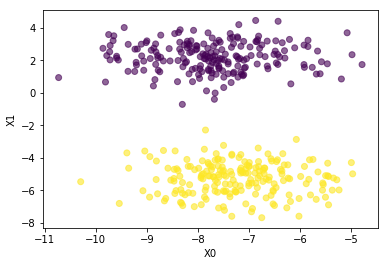

In [109]:
datasets = []
X, y = make_blobs(n_samples=400, centers=2, random_state=43)
datasets.append((X, y))
plot_data(X, y)

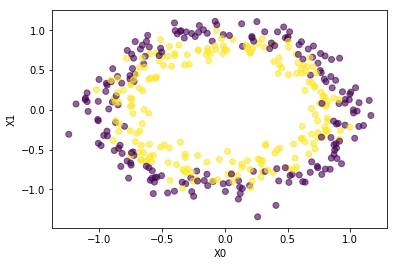

In [110]:
X, y = make_circles(n_samples=400, random_state=77, noise=0.1)
datasets.append((X, y))
plot_data(X, y)

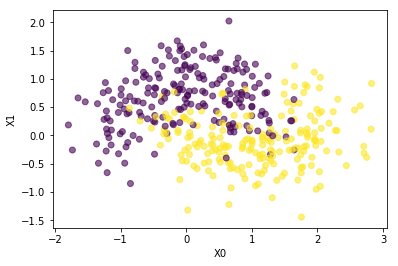

In [111]:
X, y = make_moons(n_samples=400, random_state=35, noise=0.4)
datasets.append((X, y))
plot_data(X, y)

**(1 балл)** Протестируйте линейный SVM  на сгенерированных выборках. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Проделайте это для разных значений параметра $C$ (не менее 4-х).

In [112]:
def plot_svm(ax, X, y, C):
    clf = SVC(kernel='linear', C=C)
    clf.fit(X, y)

    w = clf.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(X.min(), X.max())
    yy = a * xx - (clf.intercept_[0]) / w[1]

    b = clf.support_vectors_[0]
    yy_down = a * xx + (b[1] - a * b[0])
    b = clf.support_vectors_[-1]
    yy_up = a * xx + (b[1] - a * b[0])

    ax.plot(xx, yy, 'k-')
    ax.plot(xx, yy_down, 'k--')
    ax.plot(xx, yy_up, 'k--')

    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=80, facecolors='black')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set3', alpha=0.5)
    ax.set_title("SVM with C= %s" % (str(C)))
    
    ax.axis('tight')
    return clf.support_vectors_.shape[0]

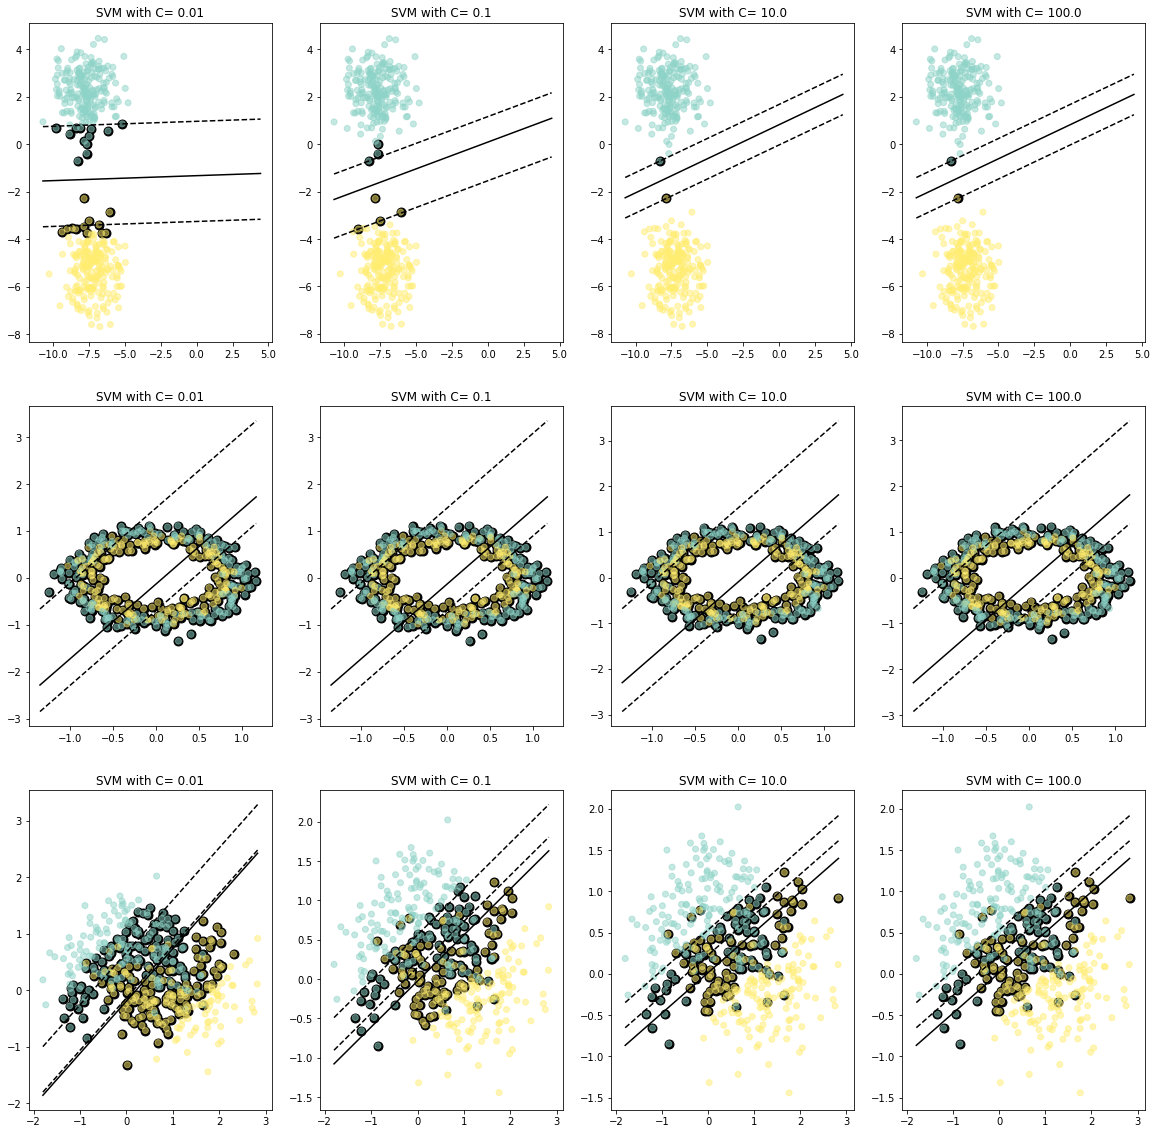

In [113]:
fig, axis = plt.subplots(3, 4, figsize=(20,20))
C = [1e-2, 1e-1, 1e+1, 1e+2]
supports_vec = np.empty((len(datasets), len(C)))
for i, data in enumerate(datasets):
    for j, c in enumerate(C):
        supports_vec[i, j] = plot_svm(axis[i,j], data[0], data[1], c)

**(1 балл)** Как зависит число опорных векторов от параметра $C$ для различных выборок?

In [114]:
supports_vec

array([[ 24.,   7.,   2.,   2.],
       [400., 400., 399., 399.],
       [285., 184., 151., 151.]])

*В случае линейно неразделимой (или плохо разделимой) выборки число опорных векторов может стать равным числу объектов.*
*В других случаях с увеличением **C** число опорных векторов уменьшается.*

#### Явное преобразование признаков

Как и в случае с линейной регрессией, когда оптимальная разделяющая гиперплоскость не является линейной, данная модель является очень грубым решением. Линейная неразделимость объектов может быть исправлена путем перехода в другое признаковое пространство, в котором линейная модель лучше описывает данные и, возможно, существует правильно классифицирующая разделяющая гиперплоскость:

$$\boldsymbol x \in \mathbb{R}^d \mapsto \phi(\boldsymbol x) \in \mathbb{R}^t$$

Так, например, аналогичное добавление всех попарных произведений признаков: $\phi(x_1, \dots, x_d) = (x_1, \dots, x_d, x_1^2, x_1x_2, \dots, x_d^2)$ переводит в пространство, в котором линейная гиперплоскость является квадратичной формой в исходном пространстве и в исходном пространстве признаков разделяющая поверхность может быть, скажем, эллипсом.

[Видеоролик с демонстрацией](https://youtu.be/9NrALgHFwTo)

### Задание

**(1 балл)** На тех же данных используя явное преобразование признаков обучите методом опорных векторов квадратичную разделяющую поверхность. Покажите на плоскости разделяющую прямую и линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Проделайте это для разных значений параметра $C$.

In [127]:
def plot_svm_poly(ax, X, y, C):
    pf = PolynomialFeatures(degree=2)
    X_poly = pf.fit_transform(X)
    
    clf = SVC(kernel='linear', C=C)
    clf.fit(X_poly, y)
    
    x_min, x_max = np.min(X_poly[:, 1]), np.max(X_poly[:, 1])
    y_min, y_max = np.min(X_poly[:, 2]), np.max(X_poly[:, 2])

    XX, YY = np.mgrid[x_min:x_max:400j, y_min:y_max:400j]
    
    Z_ = np.array([np.ones(len(XX.ravel())),
                   XX.ravel(), YY.ravel(),
                   XX.ravel() * XX.ravel(), XX.ravel() * YY.ravel(), YY.ravel() * YY.ravel()]).transpose()
    
    Z = clf.predict(Z_).reshape(XX.shape)
    Z[0][0] = 1e-6
    ax.contour(XX, YY, Z, 1, colors='black')
    
    Z = (clf.decision_function(Z_).reshape(XX.shape) >= 1).astype('float')
    Z[0][0] = 1e-6
    ax.contour(XX , YY, Z, 1, colors='black', linestyles='dashed')
    
    Z = (clf.decision_function(Z_).reshape(XX.shape) <= -1).astype('float')
    Z[0][0] = 1e-6 
    ax.contour(XX, YY, Z, 1, colors='black', linestyles='dashed')

    ax.scatter(clf.support_vectors_[:, 1], clf.support_vectors_[:, 2],
                s=80, facecolors='black')
    ax.scatter(X_poly[:, 1], X_poly[:, 2], c=y, cmap='Set3', alpha=0.5)
    ax.set_title("SVM with C= %s" % (str(C)))
    
    ax.axis('tight')
    return clf.support_vectors_.shape[0]

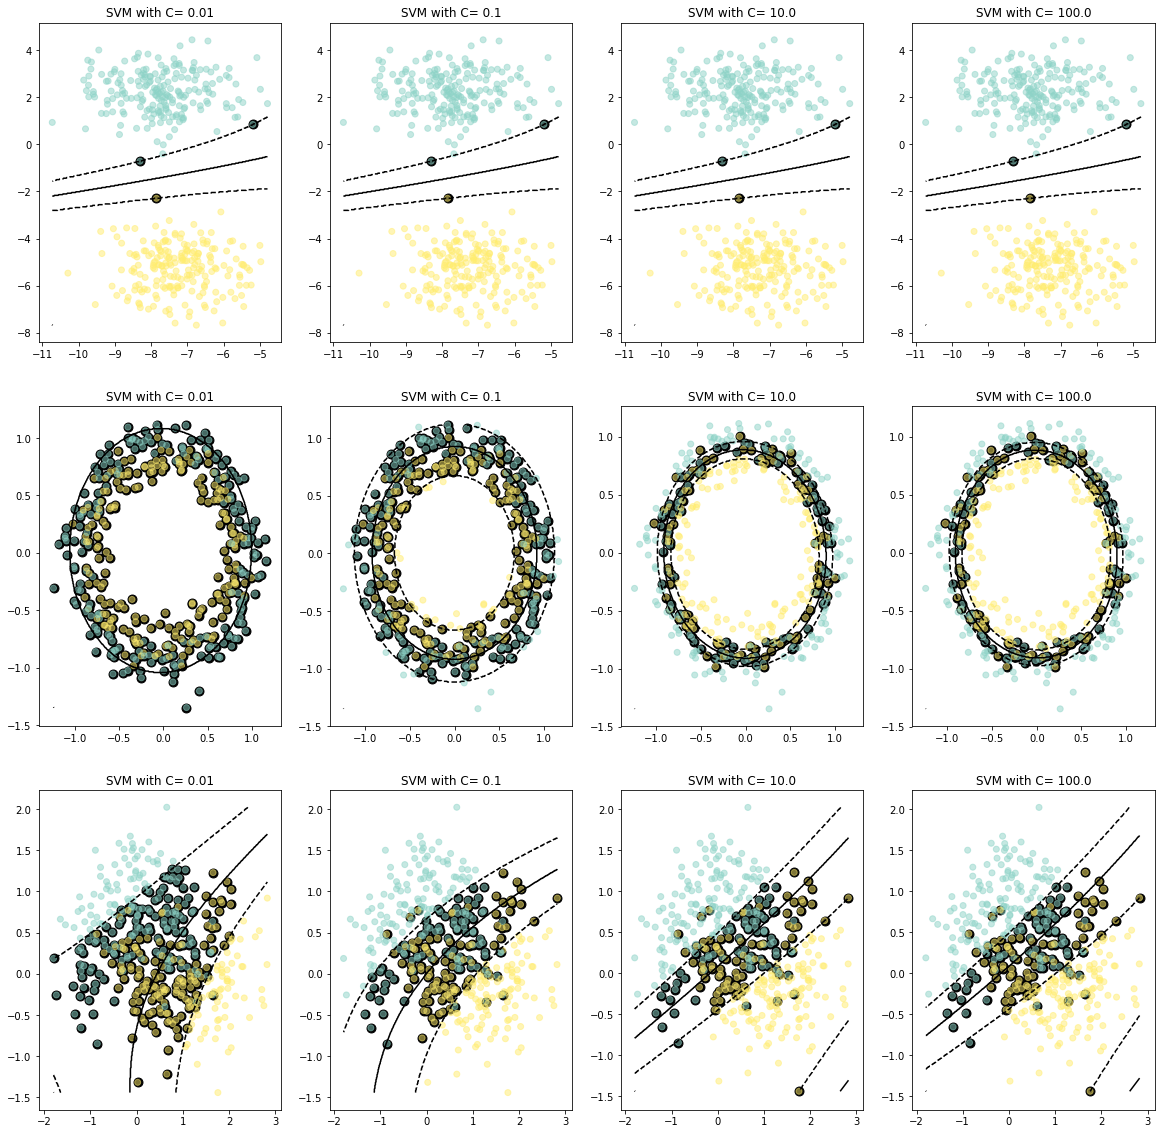

In [128]:
fig, axis = plt.subplots(len(datasets), len(C), figsize=(20,20))
supports_vec = np.empty((len(datasets), len(C)))
for i, data in enumerate(datasets):
    for j, c in enumerate(C):
        supports_vec[i, j] = plot_svm_poly(axis[i,j], data[0], data[1], c)

In [117]:
supports_vec

array([[  3.,   3.,   3.,   3.],
       [400., 362., 173., 161.],
       [270., 182., 151., 152.]])

*Тут на 2-ом датасете, уже количество опорных векторов стремительно уменьшается, вследствии того, что для SVM это уже почти линейно разделима.*

## Двойственный переход и Ядровой SVM

![](http://i.imgur.com/bJAzRCt.png)

Задачу обучения линейного SVM, рассмотренную в предыдущем пункте принято называть _прямой_ оптимизационной задачей для SVM. Любая задача оптимизации с ограничениями имеет [_двойственную_ задачу Лагранжа](http://goo.gl/OujTPr), в которой оптимизируются _двойственные переменные_ (множители Лагранжа), соответствующие штрафу за нарушение ограничений, максимизируется нижняя оценка функционала прямой задачи. В случае задачи квадратичного программирования, решение двойственной задачи (значение оптимизируемого функционала) совпадает с оптимумом прямой задачи.

Подробнее можно почитать в [статье](http://www.machinelearning.ru/wiki/images/2/25/SMAIS11_SVM.pdf).

Двойственная задача для SVM имеет вид:
$$
\begin{gather}
    \sum_{n} \alpha_n - \frac{1}{2}\sum_{n}\sum_{n'} \alpha_{n}\alpha_{n'} y_{n}y_{n'} x_{n}^Tx_{n'} \to \max_{\alpha} \\
    \begin{aligned}
        \text{s.t. } \quad  
        & 0 \le \alpha_n \le C, \quad \forall n = 1, \dots, N \\
        & \sum_{n} \alpha_n y_n = 0
    \end{aligned}
\end{gather}
$$

Оптимизируется вектор из двойственных переменных $\alpha_n$, соответствующих объектам обучающей выборки. Объект $x_n$ является опорным, если $\alpha_n > 0$.

Предсказание вычисляется по следующему правилу:
$$\hat{y}(x) = \text{sign}\left(\sum_{n}\alpha_{n}y_{n}x^Tx_{n} + b\right).$$

Для предсказания необходимо оценить значение $b$. Известно, что для любого опорного объекта, который классифицируется безошибочно верно:
$$y_n = \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'} + b,$$
значит для любого такого объекта:
$$b = y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}.$$

В случае наличия ошибок классификации обучающей выборки, предлагается усреднять значение $b$ по всем опорным векторам:
$$b = \frac{1}{N_\text{SV}}\sum_{n \in \text{SV}}\left(y_n - \sum_{n'}\alpha_{n}y_{n}x_{n}^Tx_{n'}\right).$$
Интуиция здесь такова, что суммарные ошибки в положительную сторону примерно равны суммарным ошибкам в отрицательную сторону.

Другой вариант — отказаться от параметра $b$ и работать с моделью $f(x) = w^Tx$, добавив к вектору $x$ константный признак.

#### Неявное преобразование признаков
Отметим, что двойственная задача SVM содержит вектора признаков исключительно в виде скалярного произведения $x^Tx'$. Эта особенность позволяет производить неявное преобразование признакового пространства. Вместо вычисления функции $\phi(\boldsymbol x)$, которая может отображать исходные признаки в вектора очень большой размерности, будем вычислять скалярное произведение $k(\boldsymbol x, \boldsymbol x') = \phi(\boldsymbol x)^T\phi(\boldsymbol x')$ называемое _ядром_. 


В этом задании используйте класс $sklearn.svm.SVC$, меняя тип ядра. 

### Задание

**(1.5 балла)** Протестируйте на предыдущих двумерных выборках ядровой SVM. Покажите на плоскости строящиеся разделяющие поверхности, линии уровня, ограничивающие коридор $f(\boldsymbol x) = \pm 1$. Выделите опорные вектора точками другой формы или большего размера. Попробуйте следующие ядровые функции:
- линейная: $k(x, x') = x^Tx'$
- полиномиальная: $k(x, x') = (x^Tx' + 1)^d$ с различными степенями $d = 2,3,\dots$
- Гауссовская-RBF: $k(x, x') = \exp(-\sigma\|x - x'\|^2)$

Ответьте на следующие вопросы:
 - Как ведет себя SVM с полиномиальным ядром в зависимости от параметров $C$ и степени ядра $d$?
 - Как ведет себя SVM с RBF-ядром в зависимости от параметров $C$ и $\sigma$? Поварьируйте параметры $C$ и $\sigma$ по логарифмической сетке. Какие значения параметров ведут к переобучению, а какие — к слишком грубой модели?

*C линейным было рассмотрено ранее. Рассмотрим плохо разделяемый датасет (последний)*

In [146]:
data = datasets[2]

In [145]:
def plot_svm_kernels(clf, ax, X, y, C):
    clf.fit(X, y)
    
    x_min, x_max = np.min(X[:, 0]), np.max(X[:, 0])
    y_min, y_max = np.min(X[:, 1]), np.max(X[:, 1])

    XX, YY = np.mgrid[x_min:x_max:400j, y_min:y_max:400j]
    
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])
    Z = Z.reshape(XX.shape)
    
    ax.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
                s=80, facecolors='black')
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap='Set3', alpha=0.5)
    ax.contour(XX, YY, Z, colors=['k', 'k', 'k'], linestyles=['--', '-', '--'],
                levels=[-.5, 0, .5])
        
    ax.axis('tight')
    return clf.support_vectors_.shape[0]

**Полинимиальные ядра**

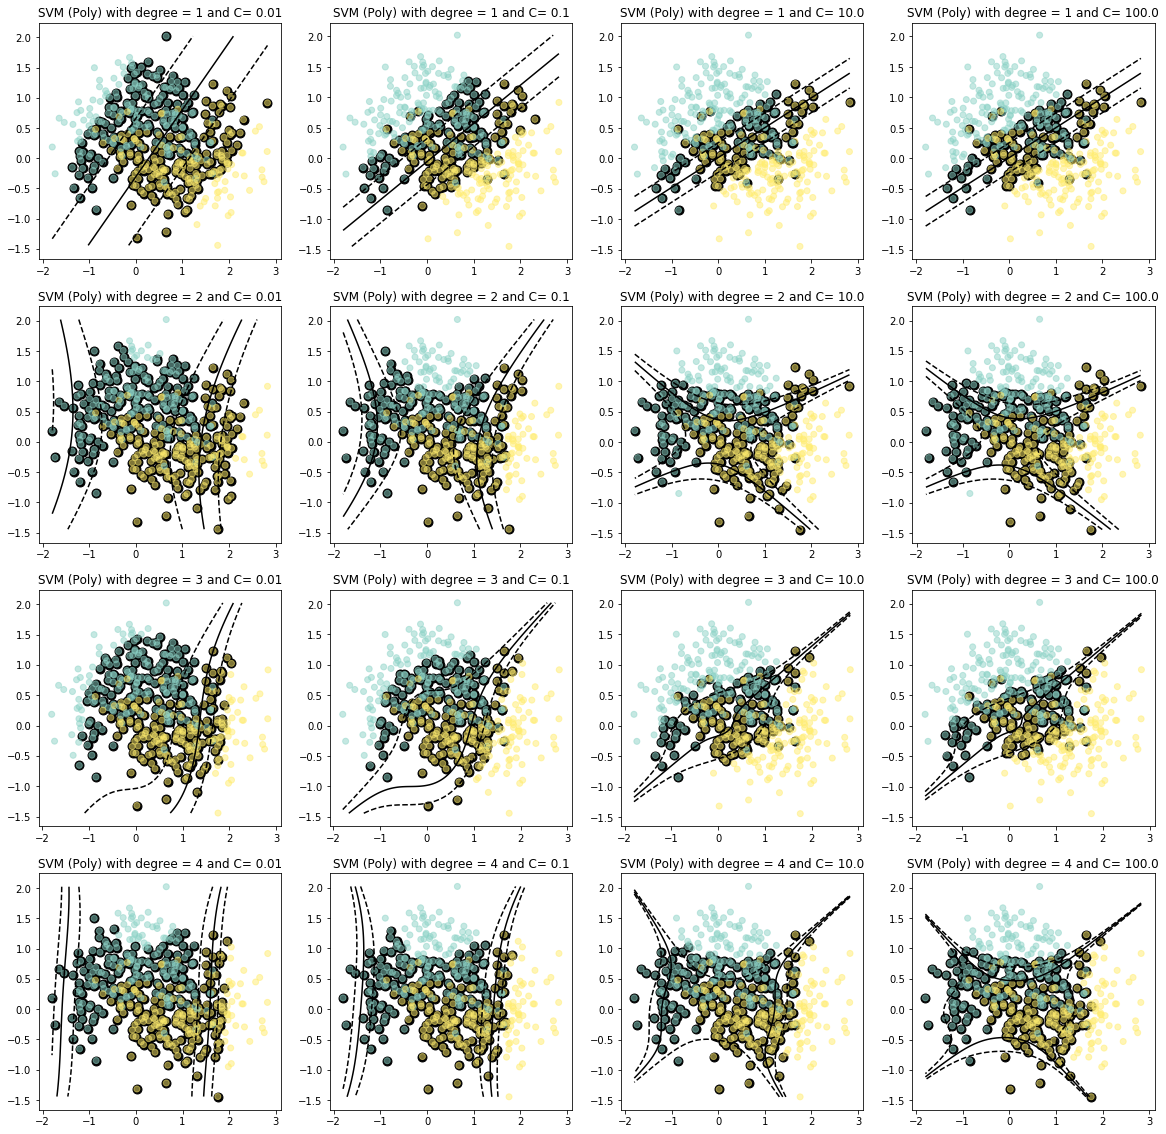

In [147]:
degrees = [1, 2, 3, 4]
fig, axis = plt.subplots(len(degrees), len(C), figsize=(20,20))
supports_vec = np.empty((len(degrees), len(C)))
for i, degree in enumerate(degrees):
    for j, c in enumerate(C):
        clf = SVC(kernel='poly', degree=degree, C=c)
        axis[i,j].set_title("SVM (Poly) with degree = %s and C= %s" % (str(degree), str(c)))
        supports_vec[i, j] = plot_svm_kernels(clf, axis[i,j], data[0], data[1], c)

*При любом размере параметра **C** модель становится лучше. С увеличением степеней идет сильная усложенение модели.*

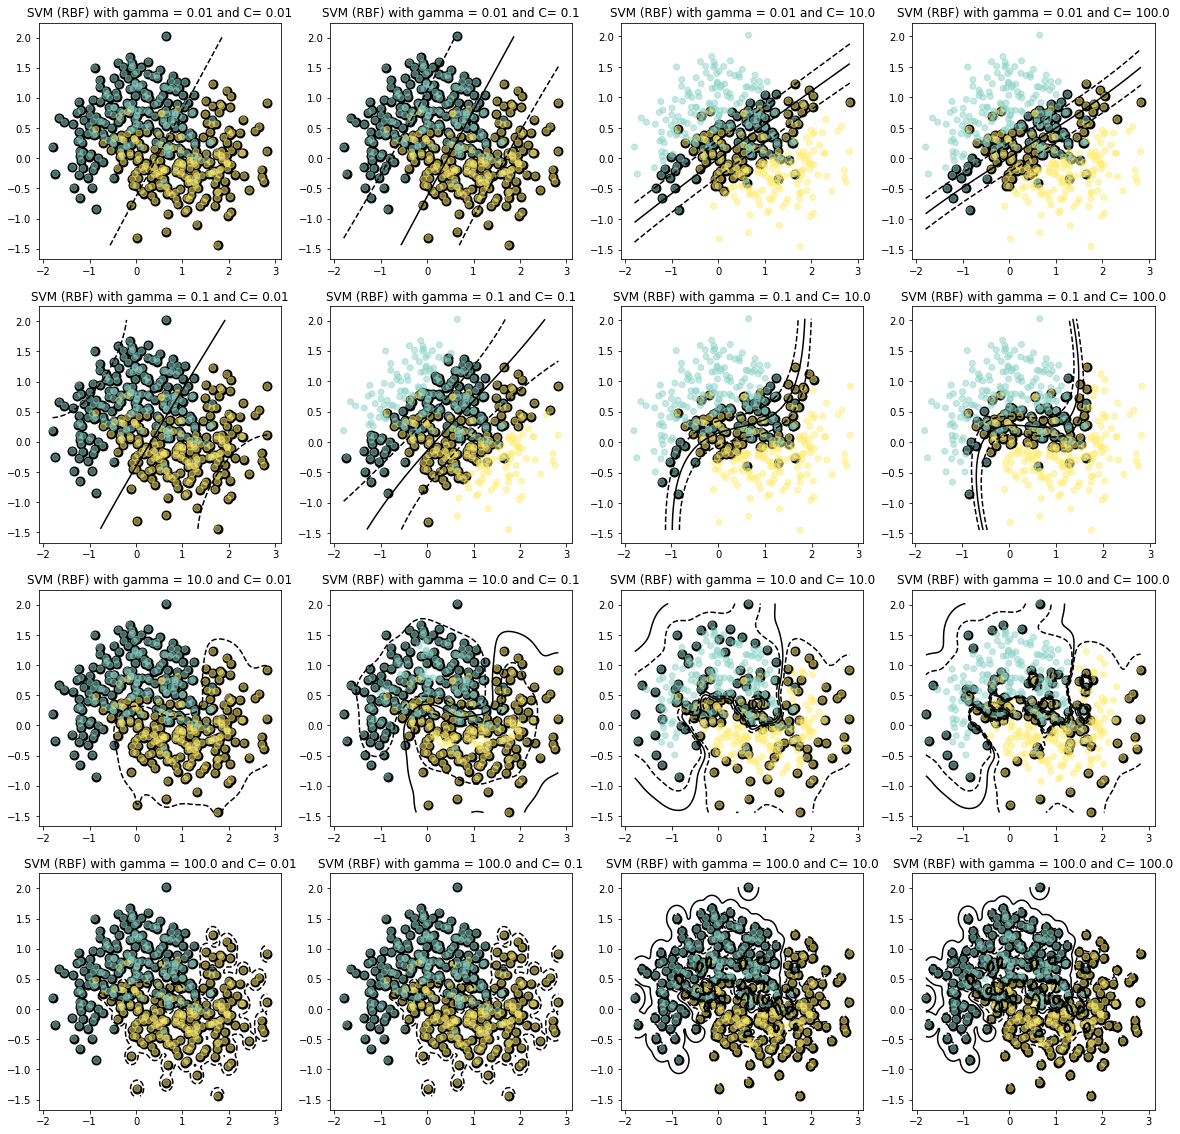

In [144]:
data = datasets[2]

gammas = [1e-2, 1e-1, 1e+1, 1e+2]
fig, axis = plt.subplots(len(gammas), len(C), figsize=(20,20))
supports_vec = np.empty((len(gammas), len(C)))
for i, gamma in enumerate(gammas):
    for j, c in enumerate(C):
        clf = SVC(kernel='rbf', gamma=gamma, C=c)
        axis[i,j].set_title("SVM (RBF) with gamma = %s and C= %s" % (str(gamma), str(c)))
        supports_vec[i, j] = plot_svm_kernels(clf, axis[i,j], data[0], data[1], c)

*При маленьком параметре **gamma** видно что модель по максимуму проста (линейное разделение), а значение **C** влияет на количество опорных векторов.*

*При большом **gamma** мы переобучаемся. Самыми хорошими моделями получилось при **gamma** равным 10 и большим значением **C**.*

## Выводы

**(1 балл)** В этой работе вы рассмотрели некоторые линейные модели машинного обучения, а также способы их обучения. Ответьте на следующие вопросы:

 - Какие есть достоинства у рассмотренных моделей? Поясните свой ответ для каждой модели.
 - Каким общим недостатком обладают данные модели? Какие есть способы его устранения? В чем может заключаться сложность использования этого подхода?
 - В чем заключаются различия с точки зрения обучения алгоритмов? Какие есть достоинства и недостатки у рассмотренных методов обучения?
 - Предположите в каком случае каждый из алгоритмов будет работать лучше: при большом/небольшом количестве данных? Поясните почему. 

##### Какие есть достоинства у рассмотренных моделей? Поясните свой ответ для каждой модели.

**Логистическая регрессия**

Достоинства:
* Простая модель
* Высокая скорость обучения
* Устойчивая к выбросам
* Небольшой набор параметров
* Предсказывает естесвенным образом вероятности
* Легко Обобщается на многоклассовый случай

**Линейная регрессия**

Достоинства:
* Простая модель
* Имеет точное аналитическое решение
* Небольшой набор параметров

**SVM**

Достоинства:
* Гибкость за счет встроенных функций

##### Каким общим недостатком обладают данные модели? Какие есть способы его устранения? В чем может заключаться сложность использования этого подхода?

Линейные модели предназначены все-же для решение линейно-разделимых задач. Решить проблему можно генерацием новых признаков из существующих, это позволит потенциально найти линейную гиперплоскость на новом пространстве. (В случае **SVM** достаточно использовать ядра). Такой подход может привести к созданию шумовых признаков, и на самом деле очень тяжело найти такое признаковое пространство.

##### В чем заключаются различия с точки зрения обучения алгоритмов? Какие есть достоинства и недостатки у рассмотренных методов обучения?

В возможных методах решения.

В **Логистической регресии** задачу можно решить только численными методами отпитимизации. В зависимоти от метода и будет зависит скорость работы алгоритма. В **Линейной регрессии** есть возомжность решить аналитически, что на самом деле получиться точно и потенциально быстрее, но также можно в принципе решить и численно. В классичиском алгоритме **SVM** решается задача квадратичного программировния, с использованием ядер, задача очень сильно усложняется и может выполняться намного дольше.

##### Предположите в каком случае каждый из алгоритмов будет работать лучше: при большом/небольшом количестве данных? Поясните почему.

**Логистическая регрессия** - работает хорошо как с большими так и маленькими данными и относительно бытсро с учетом множетсва разлиных методов оптимизации.

**Линеная регрессия** - с большими данными возможны численные проблемы аналитического решения, могут быть проблемы и с обратной матрицей.

**SVM** - с большими данными работает очень долго, в связи решением задачи квадратичного программирования, который решается за $O(N_{samples}^2N_{features})$.